In [1]:
#constants that get changed when notebook is autorun
SCOUT_FOLDER_PATH = r'C:\Users\kowaleskim\Workspace\measure_the_future\mtf_data\DB1 - Entry'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
from matplotlib.patches import Rectangle
import numpy as np

import load_mtf_data
import os

from constants import DATE_RANGE, MTF_DETECTION_PADDING
(l, t, r, b) = MTF_DETECTION_PADDING

# Measure the Future: Heatmap Visualization
This notebook creates a heatmap of interaction data from one Measure the Future Scout.

In [3]:
#set matplotlib to display plots in notbook output rather than new window
%matplotlib inline

In [4]:
#use load_mtf_data python script to get data from the most recent date range subfolder
#(interactions, im, subfolder_name) = load_mtf_data.from_most_recent_subfolder(SCOUT_FOLDER_PATH)
#(interactions, im) = load_mtf_data.from_set(SCOUT_FOLDER_PATH, "db1_10252017")
(interactions, im) = load_mtf_data.from_date_range(SCOUT_FOLDER_PATH, DATE_RANGE)

Problem loading interaction data in C:\Users\kowaleskim\Workspace\measure_the_future\mtf_data\DB1 - Entry\db1_10192017
Expecting value: line 332952 column 3 (char 2899968)
Problem loading calibration image in C:\Users\kowaleskim\Workspace\measure_the_future\mtf_data\DB1 - Entry\db1_10252017
'NoneType' object has no attribute 'read'
Problem loading interaction data in C:\Users\kowaleskim\Workspace\measure_the_future\mtf_data\DB1 - Entry\old visualizations

Problem loading calibration image in C:\Users\kowaleskim\Workspace\measure_the_future\mtf_data\DB1 - Entry\old visualizations
'NoneType' object has no attribute 'read'


None (1280, 720) L


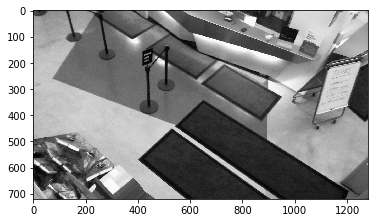

In [5]:
print(im.format, im.size, im.mode)
plt.imshow(im, cmap="gray")

In [6]:
interactions[0]

{'Duration': 15.07737,
 'EnteredAt': datetime.datetime(2017, 10, 26, 12, 45, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
 'Id': 35313,
 'Processed': True,
 'ScoutUUID': '0bfaddf8-419b-4ab1-b08d-923463118f75',
 'WaypointTimes': [8.854e-06, 15.07737],
 'WaypointWidths': [[55, 39], [56, 39]],
 'Waypoints': [[106, 595], [107, 596]]}

We will be plotting interactions by the x,y coordinates of their waypoints.  Matplotlib likes to have coordinates in separate lists for x and y, instead of a single list of x, y tuples.  Thus we will add a new key to each interaction, called "Waypoints-MPL-Format" which stores waypoint coordinates in such a manner.

In [7]:
for i in interactions: 
    i['Waypoints-MPL-Format'] = list(zip(*i['Waypoints']))
    #zip(*[(1, 4), (2, 5), (3, 6)]) -> ([1, 2, 3], [4, 5, 6])
    

interactions[0]

{'Duration': 15.07737,
 'EnteredAt': datetime.datetime(2017, 10, 26, 12, 45, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>),
 'Id': 35313,
 'Processed': True,
 'ScoutUUID': '0bfaddf8-419b-4ab1-b08d-923463118f75',
 'WaypointTimes': [8.854e-06, 15.07737],
 'WaypointWidths': [[55, 39], [56, 39]],
 'Waypoints': [[106, 595], [107, 596]],
 'Waypoints-MPL-Format': [(106, 107), (595, 596)]}

Make a custom colormap for the heatmap we're about to make.  For an indication of why this is needed, try changing cmap=cmap to cmap='rainbow' in the call to hist2d in the last cell.  There are two problems with a normal colormap like 'rainbow':
* the background image gets kind of muddy and hard to make out.
* most of the squares are very close to the low end of the colorbar, with only a handful shooting up into the high range.  There can be a big difference in practice between 0 and 500 interactions, but if there's one cell with 3000 interactions 0 and 500 will end up being visually hard to distinguish.

To solve the first issue, our custom colormap will be transparent at very low values, so the image is more visible especially in places with low traffic.  To solve the second, our custom colormap will change colors much more rapidly at lower values, so differences in low values aren't drowned out by the prescence of very high values.

In [8]:
def make_colormap_alpha(points):
    #points is a list of (location, r, g, b, a) tuples
    #where each element of the tuple is a float from 0 to 1

    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    for (location, r, g, b, a) in points:
        cdict['red'].append([location, r, r])
        cdict['green'].append([location, g, g])
        cdict['blue'].append([location, b, b])
        cdict['alpha'].append([location, a, a])
    return mpcolors.LinearSegmentedColormap('CustomMap', cdict)

cmap = make_colormap_alpha(
    [(0.0, .1, .3, .9, 0.0),
     (0.05, .1, .3, .9, 0.7),
     (0.1, .9, 0.2, .7, 1.0),
     (0.4, 0.2, .9, .7, 1.0),
     (1.0, .9, .7, 0.2, 1.0)])

In [9]:
title = "\n".join([
    "Number of Interactions by Location in Image",
    "scout: " + os.path.basename(SCOUT_FOLDER_PATH),
    "date range: " + DATE_RANGE[0].strftime('%x') + " to " + DATE_RANGE[1].strftime("%x")
])
print(title)

Number of Interactions by Location in Image
scout: DB1 - Entry
date range: 10/25/17 to 11/21/17


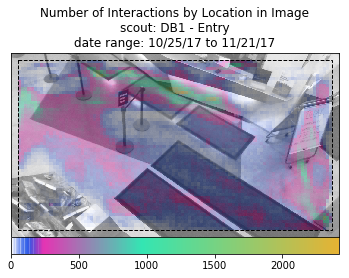

In [10]:
#get axes object from pyplot
ax = plt.axes()

flatten = lambda l: [item for sublist in l for item in sublist]

(counts, xedges, yedges, image) = ax.hist2d(
    #x, y coords
    flatten([i['Waypoints-MPL-Format'][0] for i in interactions]), 
    flatten([i['Waypoints-MPL-Format'][1] for i in interactions]),
    #set range to match size of image
    range=[[l, im.width-r], [t, im.height-b]],
    #set number of bins for each axis
    bins=[100, 50],
    cmap=cmap
    #cmap = 'rainbow'
)

plt.colorbar(
    image, #colorbar for image returned by histogram
    ax=ax, #put it on the axes object ax
    orientation="horizontal", 
    pad=0, 
    shrink=.98 #for some reason it comes out slightly larger than the image, so fix that
)

#make sure plot limits are correct
ax.set_xlim(0, 1280)
ax.set_ylim(720, 0)

#display grayscale image overlaid on histogram
ax.imshow(im, alpha=.6, cmap="gray")

ax.add_patch(
    Rectangle(
        (l, t),
        im.width-l-r, im.height-t-b,
        alpha=1, 
        fill=None,
        linestyle='dashed',
        linewidth=1
    )
)

#we don't really need axes labels for this
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.set_title(title)

plt.savefig(SCOUT_FOLDER_PATH + os.sep + "heatmap_" + str(DATE_RANGE[0]) + "_" + str(DATE_RANGE[1]) + ".jpg",
           bbox_inches='tight', dpi=300)